# Global imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, GridSearchCV
from qksvm.qksvc import QKSVC

# Customized score functions
from qksvm.scores import get_scores, print_scores, print_cv_scores

# Custom visualization tools
from qksvm.visualization_tools import plot_dataset, plot_predictions, plot_decisions

seed = 1234

# Dataset

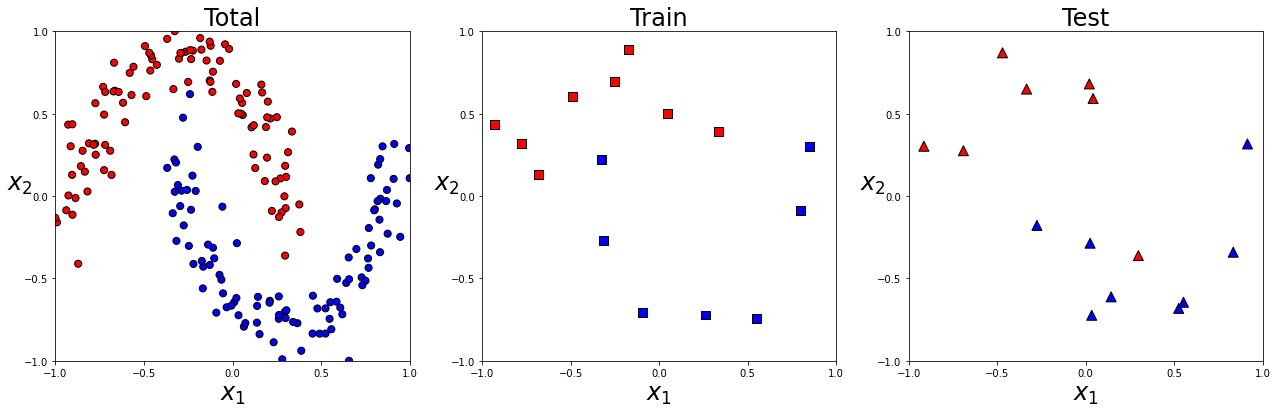

In [2]:
# Sklearn imports
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold, GridSearchCV
from sklearn import metrics
from sklearn.datasets import make_moons
np.random.seed(seed)

# Total number of the dataset points
n_samples = 200
X, y = make_moons(n_samples=n_samples, noise=0.1, random_state=seed)
y = 2*y-1 # rescale to [-1,1]

# Data rescaling
xmin = -1; xmax = 1
X = MinMaxScaler(feature_range=(xmin, xmax), copy=False).fit_transform(X)

train_size = 15 
test_size = 15 
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=train_size, 
                                                    test_size=test_size, 
                                                    stratify=y,
                                                    random_state=seed)

# Visualize the dataset
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
axes = [xmin, xmax, xmin, xmax]

ax1.set_title("Total", fontsize=24)
plot_dataset(X, y, ax1, axes)

ax2.set_title("Train", fontsize=24)
plot_dataset(X_train, y_train, ax2, axes, marker='s', size=80)

ax3.set_title("Test", fontsize=24)
plot_dataset(X_test, y_test, ax3, axes, marker='^', size=100)

plt.rcParams['font.size'] = 15
plt.tight_layout()
plt.show()

# RBF SVM

Best grid search parameters: {'C': 1, 'gamma': 5.0}
Best training score: 0.8541666666666666

Train scores:
   Balanced accuracy:  1.00
                  F1:  1.00
             ROC_AUC:  1.00
                 MCC:  1.00

Test scores:
   Balanced accuracy:  0.93
                  F1:  0.93
             ROC_AUC:  1.00
                 MCC:  0.87


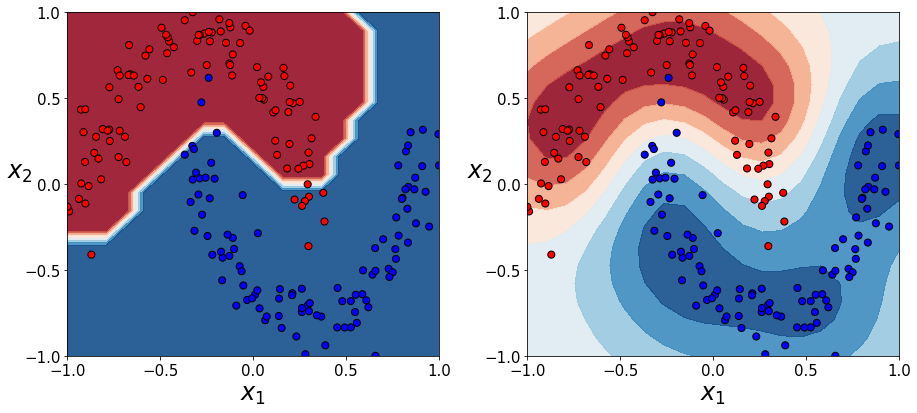

In [3]:
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, GridSearchCV
from sklearn.svm import SVC

param_grid = {
    "gamma": [0.001, 0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 5.0, 10.0],
    "C": [1, 2, 4, 6, 8, 10, 100, 1000, 2000, 3000],
}

clf = GridSearchCV(
    estimator=SVC(kernel='rbf'),
    param_grid=param_grid,
    scoring='balanced_accuracy',
    n_jobs=1,
    refit=True,
    cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=seed),
)
clf.fit(X_train, y_train)

print('Best grid search parameters:', clf.best_params_)
print('Best training score:', clf.best_score_)

train_scores = get_scores(clf.best_estimator_, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(clf.best_estimator_, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
plot_predictions(clf.best_estimator_, ax1, axes, N=20)
plot_dataset(X, y, ax1, axes)
plot_decisions(clf.best_estimator_, ax2, axes, N=20)
plot_dataset(X, y, ax2, axes)
plt.tight_layout()
plt.show()

## Model cross-validation

In [4]:
np.random.seed(seed)

scoring = 0 # 0=acc, 1=f1, 2=roc
best_score = 0.0
scores_tr = []
scores_tt = []

param_grid = {
    "gamma": [0.001, 0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 5.0, 10.0],
    "C": [1, 2, 4, 6, 8, 10, 100, 1000, 2000, 3000],
}

# train_size = 20
# test_size = 20
n_splits = 5

for _seed in np.random.randint(2**16-1, size=5):
    # print('rnd seed', _seed)

    cv = StratifiedShuffleSplit(
        n_splits=n_splits, 
        train_size=train_size, test_size=test_size, 
        random_state=_seed
    )

    i = 0
    for train, test in cv.split(X, y):
        i += 1
        # print(f"Train/Test CV Subset {i}")

        clf = GridSearchCV(
            estimator=SVC(kernel='rbf'),
            param_grid=param_grid,
            scoring='matthews_corrcoef',
            n_jobs=1,
            refit=True,
            cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=_seed),
        )

        clf.fit(X[train,:], y[train])

        train_scores = get_scores(clf.best_estimator_, X[train,:], y[train])
        test_scores = get_scores(clf.best_estimator_, X[test,:], y[test])
        scores_tr.append(train_scores)
        scores_tt.append(test_scores)
        if test_scores[scoring] > best_score:
            best_score = test_scores[scoring]
            best_clf = clf.best_estimator_

print('')
print('==== Cross-Validation Scores ====')
print("\nBest train score: ", best_score)
print_cv_scores(scores_tr, title='Train set:')
print_cv_scores(scores_tt, title='Test set:')


==== Cross-Validation Scores ====

Best train score:  1.0

Train set:
   Balanced accuracy:  0.96 +- 0.05
                  F1:  0.96 +- 0.05
             ROC_AUC:  0.99 +- 0.03
                 MCC:  0.92 +- 0.10

Test set:
   Balanced accuracy:  0.89 +- 0.09
                  F1:  0.89 +- 0.09
             ROC_AUC:  0.96 +- 0.06
                 MCC:  0.80 +- 0.17


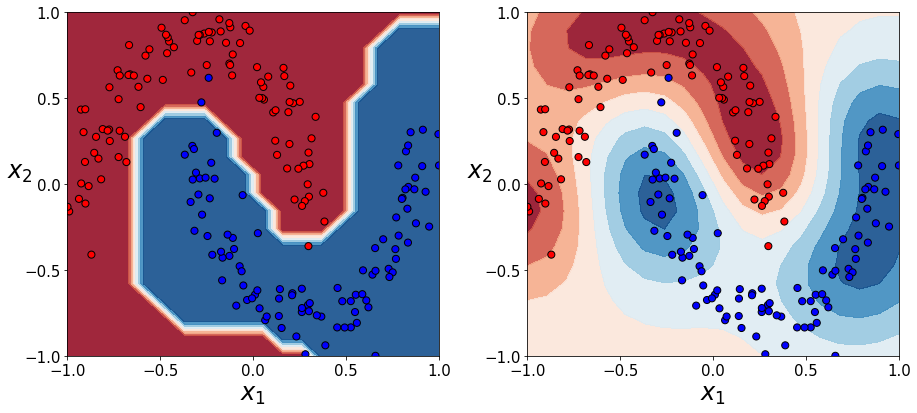

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
plot_predictions(best_clf, ax1, axes, N=20)
plot_dataset(X, y, ax1, axes)
plot_decisions(best_clf, ax2, axes, N=20)
plot_dataset(X, y, ax2, axes)
plt.tight_layout()
plt.show()

# QKSVC

In [6]:
def model(params):

    qsvc = QKSVC(
        n_qubits=params['n_qubits'],
        n_layers=params['n_layers'],
        feature_map=params['feature_map'], entanglement='linear',
        alpha=params['alpha'], C=params['C'], 
        random_state=seed
    )
    qsvc.fit(X_train, y_train)

    train_scores = get_scores(qsvc, X_train, y_train)
    print_scores(train_scores, title='Train scores:')

    test_scores  = get_scores(qsvc, X_test,  y_test)
    print_scores(test_scores, title='Test scores:')

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
    plot_predictions(qsvc, ax1, axes, N=20)
    plot_dataset(X, y, ax1, axes)
    plot_decisions(qsvc, ax2, axes, N=20)
    plot_dataset(X, y, ax2, axes)
    plt.tight_layout()
    plt.show()

## Hyperparameter search

Best grid search parameters: {'C': 1, 'alpha': 1.5, 'feature_map': ['rx', 'ry', 'cz'], 'n_layers': 2, 'n_qubits': 2}
Best training score: 1.0

Train scores:
   Balanced accuracy:  1.00
                  F1:  1.00
             ROC_AUC:  1.00
                 MCC:  1.00

Test scores:
   Balanced accuracy:  0.93
                  F1:  0.93
             ROC_AUC:  1.00
                 MCC:  0.87


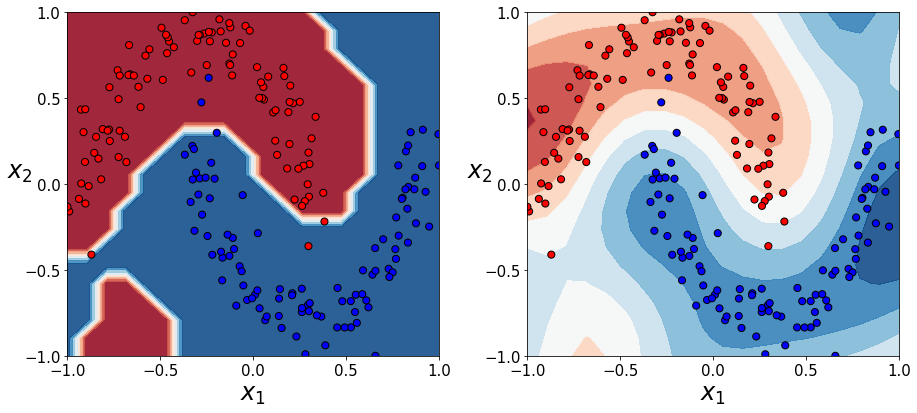

In [12]:
np.random.seed(seed=seed)

param_grid = {
    "alpha": [1.0, 1.5, 2.0, 2.5, 3.0],
    "C": [1, 10],
    "n_layers": [1, 2, 3, 4],
    "n_qubits": [2, 3, 4],
    "feature_map": [
                    ['rx', 'cz'], 
                    ['rx', 'cx'], 
                    ['rx', 'swap'],
                    ['ry', 'cz'], 
                    ['ry', 'cx'], 
                    ['ry', 'iswap'],
                    ['ry', 'crx'],
                    ['rx', 'cry'],
                    ['rx', 'crz'],
                    ['rx', 'ry', 'cz'],
                    ['rx', 'ry', 'cx'],
                    ['rx', 'ry', 'swap'],
                    ['rx', 'ry', 'rz', 'cz'],
                   ],
}

gs = GridSearchCV(
    estimator=QKSVC(entanglement='linear', random_state=seed),
    param_grid=param_grid,
    scoring='matthews_corrcoef',
    n_jobs=1,
    refit=True,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=seed),
)
gs.fit(X_train, y_train)

print('Best grid search parameters:', gs.best_params_)
print('Best training score:', gs.best_score_)

train_scores = get_scores(gs.best_estimator_, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(gs.best_estimator_, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
plot_predictions(gs.best_estimator_, ax1, axes, N=20)
plot_dataset(X, y, ax1, axes)
plot_decisions(gs.best_estimator_, ax2, axes, N=20)
plot_dataset(X, y, ax2, axes)
plt.tight_layout()
plt.show()

267
604
1.0
params {'C': 1, 'alpha': 2.5, 'feature_map': ['rx', 'ry', 'swap'], 'n_layers': 2, 'n_qubits': 3}

Train scores:
   Balanced accuracy:  1.00
                  F1:  1.00
             ROC_AUC:  1.00
                 MCC:  1.00

Test scores:
   Balanced accuracy:  1.00
                  F1:  1.00
             ROC_AUC:  1.00
                 MCC:  1.00


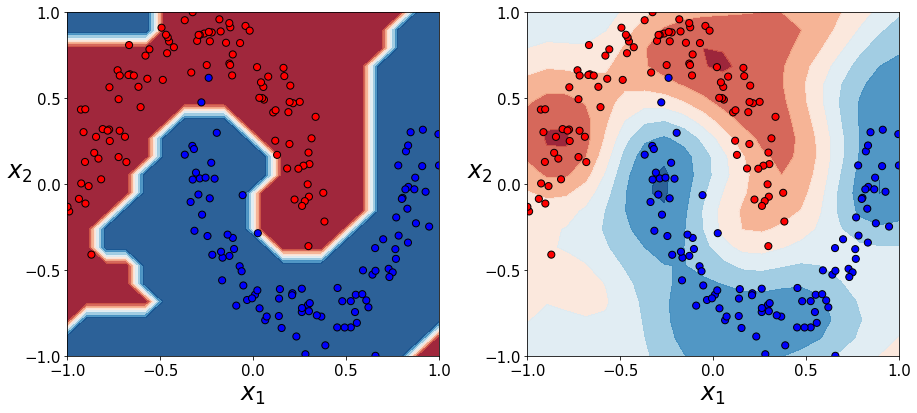

In [16]:
print(gs.best_index_)

i = -3
idx = np.argsort(gs.cv_results_['mean_test_score'])
print(idx[i])
print(gs.cv_results_['mean_test_score'][idx[i]])
print('params', gs.cv_results_['params'][idx[i]])

model(gs.cv_results_['params'][idx[i]])

267
580
1.0
params {'C': 1, 'alpha': 2.5, 'feature_map': ['rx', 'ry', 'cz'], 'n_layers': 2, 'n_qubits': 3}

Train scores:
   Balanced accuracy:  1.00
                  F1:  1.00
             ROC_AUC:  1.00
                 MCC:  1.00

Test scores:
   Balanced accuracy:  0.94
                  F1:  0.93
             ROC_AUC:  1.00
                 MCC:  0.88


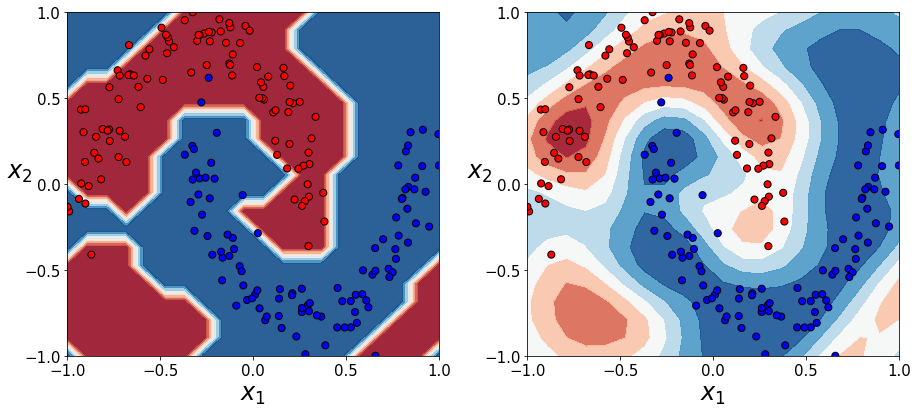

In [17]:
print(gs.best_index_)

i = -4
idx = np.argsort(gs.cv_results_['mean_test_score'])
print(idx[i])
print(gs.cv_results_['mean_test_score'][idx[i]])
print('params', gs.cv_results_['params'][idx[i]])

model(gs.cv_results_['params'][idx[i]])

## Model cross-validation

In [20]:
np.random.seed(seed)

scoring = 0 # 0=acc, 1=f1, 2=roc
best_score = 0.0
scores_tr = []
scores_tt = []

train_size = 15
test_size = 15
n_splits = 5

for _seed in np.random.randint(2**16-1, size=5):
    # print('rnd seed', _seed)

    cv = StratifiedShuffleSplit(
        n_splits=n_splits, 
        train_size=train_size, test_size=test_size, 
        random_state=_seed
    )

    i = 0
    for train, test in cv.split(X, y):
        i += 1
        # print(f"Train/Test CV Subset {i}")

        params = {'C': 1, 'alpha': 1.5, 'feature_map': ['rx', 'ry', 'cz'], 'n_layers': 2, 'n_qubits': 2}
        qsvc = QKSVC(
            n_qubits=params['n_qubits'],
            n_layers=params['n_layers'],
            feature_map=params['feature_map'], entanglement='linear',
            alpha=params['alpha'], C=params['C'], 
            random_state=seed
        )
        qsvc.fit(X[train,:], y[train])

        train_scores = get_scores(qsvc, X[train,:], y[train])
        test_scores = get_scores(qsvc, X[test,:], y[test])
        scores_tr.append(train_scores)
        scores_tt.append(test_scores)
        if test_scores[scoring] > best_score:
            best_score = test_scores[scoring]
            best_qsvc = qsvc

print('')
print('==== Cross-Validation Scores ====')
print("\nBest train score: ", best_score)
print_cv_scores(scores_tr, title='Train set:')
print_cv_scores(scores_tt, title='Test set:')


==== Cross-Validation Scores ====

Best train score:  1.0

Train set:
   Balanced accuracy:  0.99 +- 0.02
                  F1:  0.99 +- 0.02
             ROC_AUC:  1.00 +- 0.00
                 MCC:  0.98 +- 0.04

Test set:
   Balanced accuracy:  0.98 +- 0.04
                  F1:  0.98 +- 0.05
             ROC_AUC:  0.99 +- 0.03
                 MCC:  0.96 +- 0.08


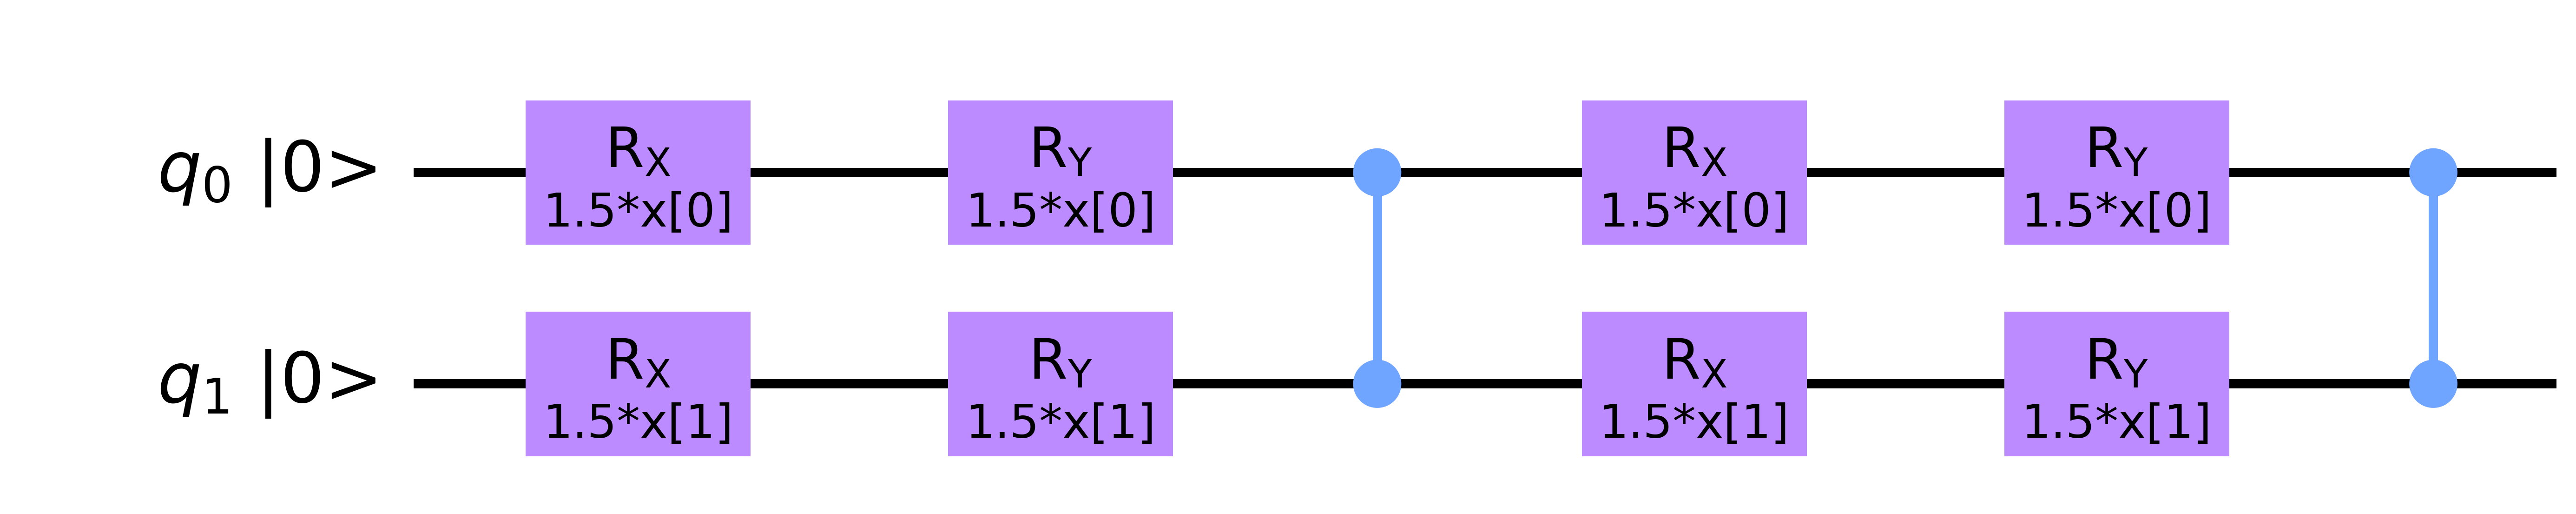

In [1]:
from qksvm.QuantumFeatureMap import QuantumFeatureMap

 # {'C': 1, 'alpha': 1.5, 'feature_map': ['rx', 'ry', 'cz'], 'n_layers': 2, 'n_qubits': 2}
    
## Specify Feature Map
fm = QuantumFeatureMap(
    num_features=2, 
    num_qubits=2,
    num_layers=2,
    gates=['RX', 'RY', 'CZ'], entanglement='linear',
    alpha=1.5
)

large_font = {
    "fontsize": 12,
    "subfontsize": 10,  
}
fm.draw(plot_barriers=False, fold=180, output='mpl', scale=10, style=large_font, initial_state=True)